In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, EvokedArray, set_log_level
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter

from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg')
epochs.drop_channels(epochs.info['bads'])

Number of events,42
Events,left: 8r_pinch: 8r_stop: 7rest: 11right: 8
Time range,-2.000 – 7.999 sec
Baseline,off


Get Subset

In [3]:
classes = ['left','right']
subset = epochs[classes].copy()
subset.apply_baseline((-1.6,-0.4))

Number of events,16
Events,left: 8right: 8
Time range,-2.000 – 7.999 sec
Baseline,-1.600 – -0.400 sec


PCA

In [4]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=34)
lda = LinearDiscriminantAnalysis()
le = LabelEncoder()

Temporal Features

In [5]:
def avg(x): 
    return np.average(x)

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def median_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]
    
def entropy(x):
    max_a = max(x) if max(x) > 0 else -max(x)
    min_a = min(x)
    ampl = np.linspace(min_a, max_a, len(x))
    kernel = gaussian_kde(x, bw_method='silverman')
    p = np.array(kernel(x) / np.sum(kernel(x)))
    
    if np.sum(p) == 0:
        return 0.0
    p = p[np.where(p != 0)]
    
    if np.log2(len(x)) == 1:
        return 0.0
    
    ent = np.sum(p*np.log2(p)) / np.log2(len(x))
    if ent == 0:
        return 0.0
    return -ent 



In [6]:
freqs = [2.,7.,18.,35.,60.,70.,90.,110.,120.,130,140]
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
scores = []
time_config = [
    (1,0.2,1200,0),
    (3,0.2,300,0),
    (3,0.4,500,200),
    (3,0.4,400,200),
    (3,0.4,300,100),
]
components = [0.65, 0.75, 0.85]

In [7]:
X = subset.copy().crop(-1,1.8)
y = le.fit_transform(X.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

In [8]:
scores = []
features = 5
for component in components:
    pca_score = []
    pca = PCA(n_components=component)
    print('pca', component)
    for cnf in time_config:
        print('config',cnf)
        n_windows, t_min, width, overlap = cnf
        freq_labels = []
        freq_scores = []

        for freq, (fmin, fmax) in enumerate(freq_ranges):
            test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
            cv_split = cv.split(test)

            cv_scr = np.zeros((features,len(freq_ranges)))
            split = 0
            for train_idx, test_idx in cv_split:
                y_train, y_test = y[train_idx], y[test_idx]
                X_train = []
                X_test = []
                x_tr = test[train_idx]
                n_eps, n_chan, n_time = x_tr.shape
                x_tr = np.transpose(x_tr,(1,0,2)).reshape(n_chan, n_eps*n_time).T
                pca.fit(x_tr)
                w_min = 0
                for i in range(n_windows):
                    w_max = w_min + width
                    x_tr = test[train_idx,:,w_min:w_max]
                    n_eps, n_chan, n_time = x_tr.shape
                    x_tr = np.transpose(x_tr,(1,0,2)).reshape(n_chan, n_eps*n_time).T
                    x_tr = pca.transform(x_tr)
                    x_tr = x_tr.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

                    try:
                        X_train[0] = np.concatenate([X_train[0], np.apply_along_axis(avg, 2, x_tr**2)], axis=1)
                    except:
                        X_train.append(np.apply_along_axis(avg, 2, x_tr**2))
                    try:
                        X_train[1] = np.concatenate([X_train[1], np.apply_along_axis(autocorr, 2, x_tr)], axis=1)
                    except:
                        X_train.append(np.apply_along_axis(autocorr, 2, x_tr))
                    try:
                        X_train[2] = np.concatenate([X_train[2], np.apply_along_axis(temp_centroid, 2, x_tr)], axis=1)
                    except:
                        X_train.append(np.apply_along_axis(temp_centroid, 2, x_tr))
                    try:
                        X_train[3] = np.concatenate([X_train[3], np.apply_along_axis(mean_abs_diff, 2, x_tr)], axis=1)
                    except:
                        X_train.append(np.apply_along_axis(mean_abs_diff, 2, x_tr))
                    try:
                        X_train[4] = np.concatenate([X_train[4], np.apply_along_axis(slope, 2, x_tr)], axis=1)
                    except:
                        X_train.append(np.apply_along_axis(slope, 2, x_tr))

                    x_tst = test[test_idx,:,w_min:w_max]
                    n_eps, n_chan, n_time = x_tst.shape
                    x_tst = np.transpose(x_tst,(1,0,2)).reshape(n_chan, n_eps*n_time).T
                    x_tst = pca.transform(x_tst)
                    x_tst = x_tst.T.reshape((-1, n_eps, n_time)).transpose((1,0,2))

                    try:
                        X_test[0] = np.concatenate([X_test[0], np.apply_along_axis(avg, 2, x_tst**2)], axis=1)
                    except:
                        X_test.append(np.apply_along_axis(avg, 2, x_tst**2))
                    try:
                        X_test[1] = np.concatenate([X_test[1], np.apply_along_axis(autocorr, 2, x_tst)], axis=1)
                    except:
                        X_test.append(np.apply_along_axis(autocorr, 2, x_tst))
                    try:
                        X_test[2] = np.concatenate([X_test[2], np.apply_along_axis(temp_centroid, 2, x_tst**2)], axis=1)
                    except:
                        X_test.append(np.apply_along_axis(temp_centroid, 2, x_tst))
                    try:
                        X_test[3] = np.concatenate([X_test[3], np.apply_along_axis(mean_abs_diff, 2, x_tst)], axis=1)
                    except:
                        X_test.append(np.apply_along_axis(mean_abs_diff, 2, x_tst))
                    try:
                        X_test[4] = np.concatenate([X_test[4], np.apply_along_axis(slope, 2, x_tst)], axis=1)
                    except:
                        X_test.append(np.apply_along_axis(slope, 2, x_tst))

                    w_min += w_max - overlap

                for ft in range(len(X_train)):
                    len(X_train[ft])
                    lda.fit(X_train[ft],y_train)
                    cv_scr[ft,split] = lda.score(X_test[ft], y_test)
                split += 1

            freq_scores.append(cv_scr)
        pca_score.append(freq_scores)
    scores.append(pca_score)
                

pca 0.65
config (1, 0.2, 1200, 0)
config (3, 0.2, 300, 0)
config (3, 0.4, 500, 200)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


config (3, 0.4, 400, 200)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


config (3, 0.4, 300, 100)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


pca 0.75
config (1, 0.2, 1200, 0)
config (3, 0.2, 300, 0)
config (3, 0.4, 500, 200)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


config (3, 0.4, 400, 200)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


config (3, 0.4, 300, 100)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


pca 0.85
config (1, 0.2, 1200, 0)
config (3, 0.2, 300, 0)
config (3, 0.4, 500, 200)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


config (3, 0.4, 400, 200)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


config (3, 0.4, 300, 100)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5916\3347978082.py:14: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax,verbose=None,n_jobs=4).get_data()


In [9]:
medians = np.apply_along_axis(np.median,4,scores)

In [10]:
name = 'scores_pca_{}_{}.npy'.format(classes[0],classes[1]) if chance < 0.565 else 'scores_pca_UN_{}_{}.npy'.format(classes[0],classes[1])
np.save(name, np.array(medians))

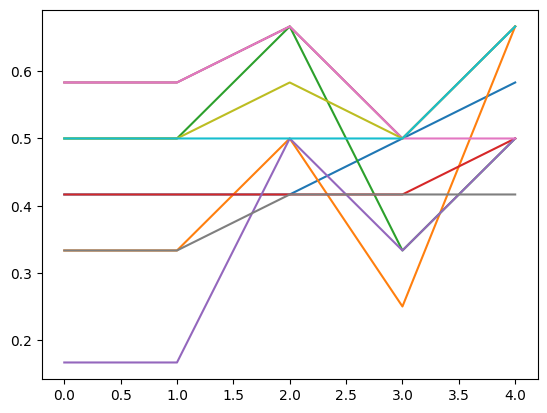

In [84]:
i = 0
for cnf in time_config:
    j = 0
    n_windows, t_min, width, overlap = cnf
    csp_fig, axes = plt.subplots(1)
    axes.plot(medians[i].T)
    i+=1

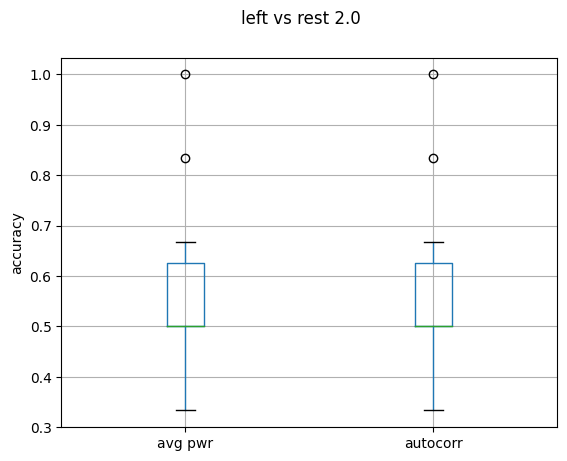

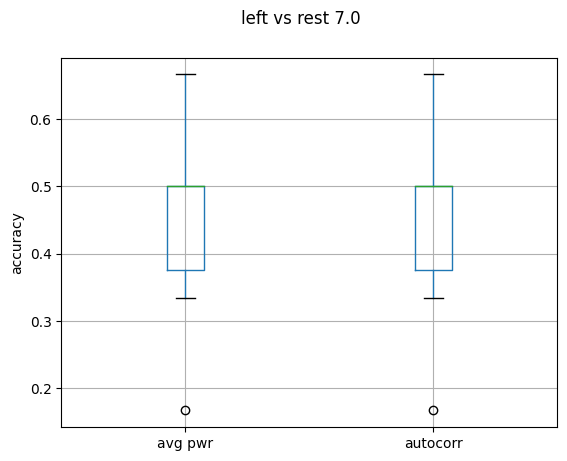

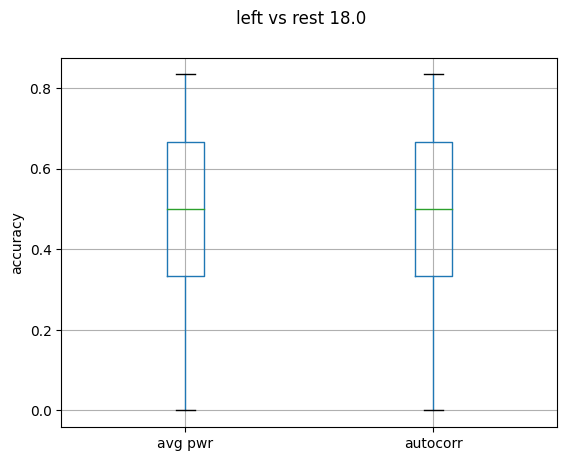

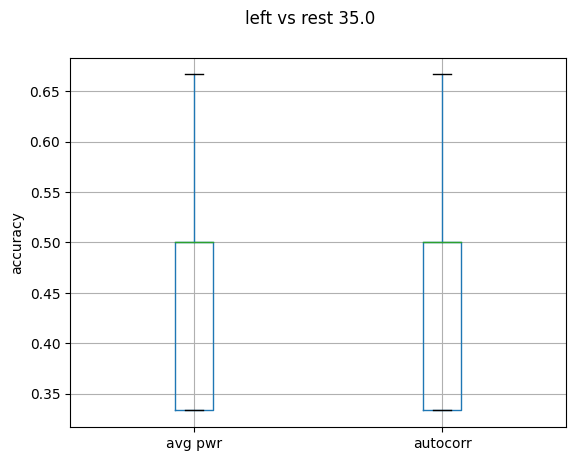

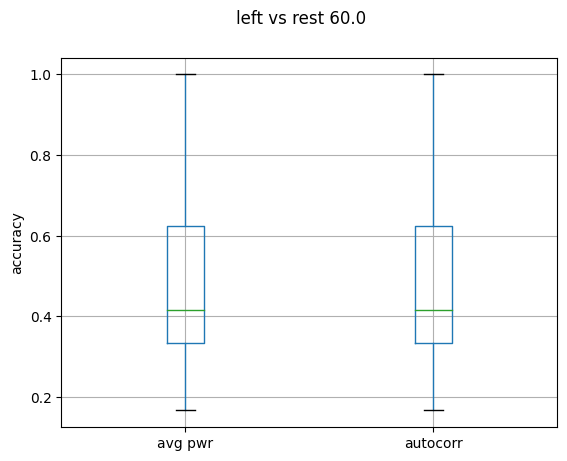

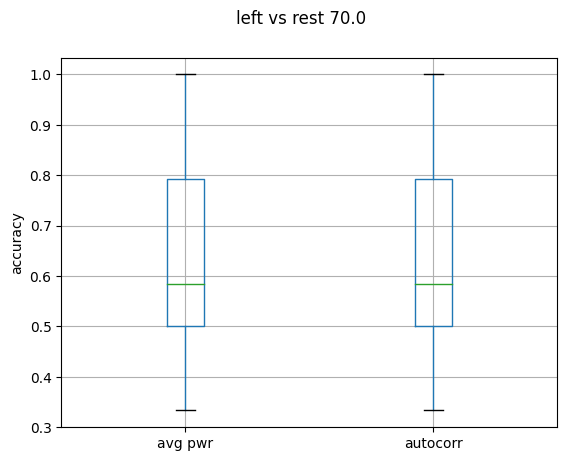

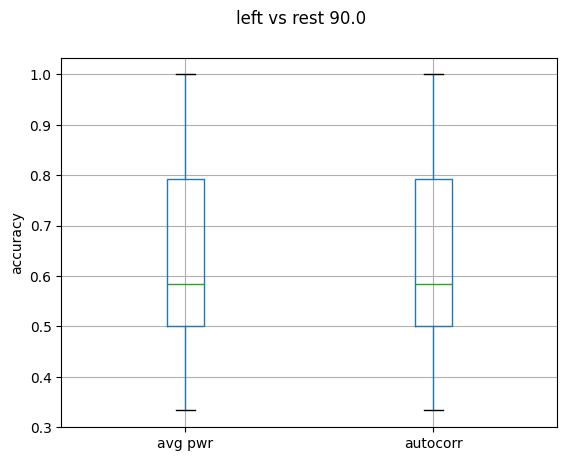

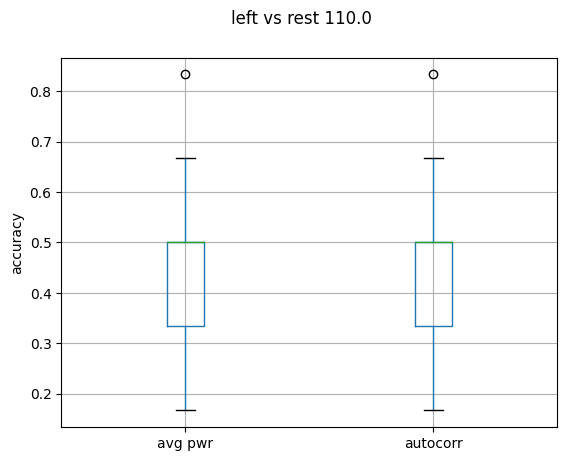

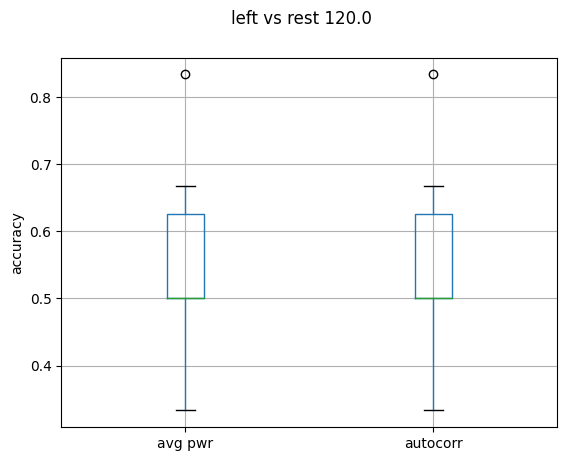

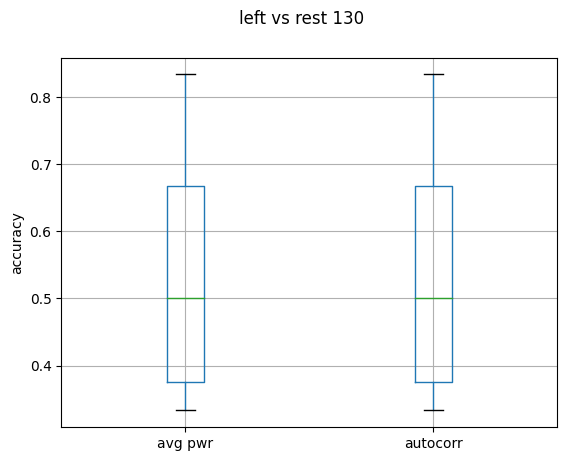

In [159]:
l_scores = []
i = 0
for cnf in time_config:
    n_windows, t_min, width, overlap = cnf
    
    for freq in range(10):
        scores_df = pd.DataFrame(data=np.transpose(np.array(scores)[1,freq,:,:]), columns=['avg pwr', 'autocorr'])
        csp_fig, axes = plt.subplots(1)
        scores_df.boxplot(ax=axes)
        axes.set_ylabel('accuracy')
        csp_fig.suptitle('left vs rest {}'.format(freqs[freq]))
        plt.show()
    i+=1
    break

In [48]:
winds_features, n_epochs, pca_comp= np.array(X_train).shape

In [69]:
 int(winds_features/n_windows)

2

In [82]:
shaped = np.array(X_train).transpose(1,0,2).reshape( n_epochs , int(winds_features/n_windows), pca_comp*n_windows,)

In [83]:
shaped.shape

(21, 2, 26)

In [427]:
#Average power
X_avg = np.apply_along_axis(avg, 2, X_power)
X_avg.shape

(27, 12)

In [428]:
#Autocorrelation
X_autoc = np.apply_along_axis(autocorr, 2, X)
X_autoc.shape

(27, 12)

In [429]:
#Temporal centroid
X_centr = np.apply_along_axis(temp_centroid, 2, X_power)
X_centr.shape

(27, 12)

In [430]:
#Mean absolute difference
X_mean_abs_dff = np.apply_along_axis(mean_abs_diff, 2, X)
X_mean_abs_dff.shape

(27, 12)

In [431]:
#Median absolute difference
X_median_abs_dff = np.apply_along_axis(median_abs_diff, 2, X)
X_median_abs_dff.shape

(27, 12)

In [432]:
#Slope
X_slope = np.apply_along_axis(slope, 2, X)
X_slope.shape

(27, 12)

In [433]:
#Entropy with Kernel estimator
X_ent = np.apply_along_axis(entropy, 2, X)
X_ent.shape

(27, 12)

Classification

In [434]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=34)
lda = LinearDiscriminantAnalysis()

In [435]:
scores_avg = cross_val_score(lda, X_avg, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_autoc = cross_val_score(lda, X_autoc, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_centr = cross_val_score(lda, X_centr, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_mean_dff = cross_val_score(lda, X_mean_abs_dff, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_median_dff = cross_val_score(lda, X_median_abs_dff, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_slope = cross_val_score(lda, X_mean_abs_dff, y, scoring='accuracy', cv=cv, n_jobs=4)
scores_ent = cross_val_score(lda, X_ent, y, scoring='accuracy', cv=cv, n_jobs=4)


In [436]:
scores = [scores_avg, scores_autoc, scores_centr, scores_mean_dff, scores_median_dff, scores_slope, scores_ent]
scores_df = pd.DataFrame(data=np.transpose(scores), columns=['avg pwr', 'autocorr', 'centroid', 'mean abs dff', 'med abs dff', 'slope', 'entropy'])

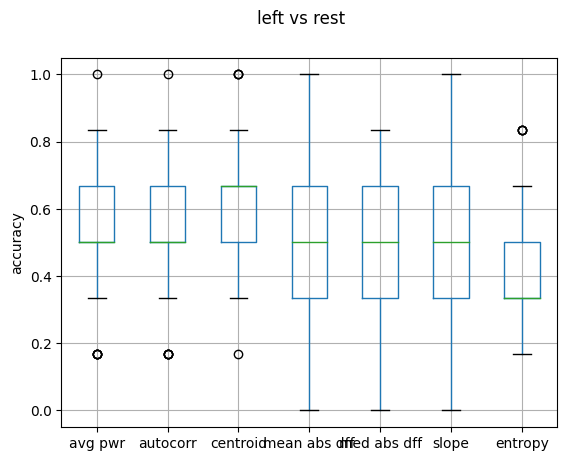

In [437]:
csp_fig, axes = plt.subplots(1)
scores_df.boxplot(ax=axes)
axes.set_ylabel('accuracy')
csp_fig.suptitle('left vs rest')
plt.show()